# Advanced Analytics Challenge - LATAM Airlines

### Fernando Greve <br> fgreve@gmail.com <br> www.fernandogreve.com


In [1]:
# definir el tamaño de la muestra que se utiliza para entrenar
# Definí un tamaño pequeño por un tema de tiempo y xq me imagino van a revisar hartos modelos de todos los postulantes.
test_size = 0.8

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sweetviz as sv # libreria para EDA
import datetime 
from datetime import datetime
from dateutil.relativedelta import relativedelta
from datetime import date
import numpy as np
import seaborn as sns

import psutil

# classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# preprocessing
from sklearn.preprocessing import LabelEncoder

# tools
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve, validation_curve
import warnings

warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("dataset_SCL.csv")

## 1. ¿Cómo se distribuyen los datos? ¿Qué te llama la atención o cuál es tu conclusión sobre esto?

In [4]:
df = df.astype('category')
df['Fecha-I']= pd.to_datetime(df['Fecha-I'])
df['Fecha-O']= pd.to_datetime(df['Fecha-O'])

df.dtypes

Fecha-I      datetime64[ns]
Vlo-I              category
Ori-I              category
Des-I              category
Emp-I              category
Fecha-O      datetime64[ns]
Vlo-O              category
Ori-O              category
Des-O              category
Emp-O              category
DIA                category
MES                category
AÑO                category
DIANOM             category
TIPOVUELO          category
OPERA              category
SIGLAORI           category
SIGLADES           category
dtype: object

## Variables relevantes:

- Fecha-O : Fecha y hora de operación del vuelo.
- Des-O : Código de ciudad de destino de operación.
- Emp-O : Código aerolínea de vuelo operado.
- OPERA : Nombre de aerolínea que opera.
- SIGLADES : Nombre ciudad destino.
- MES: Número de mes de operación del vuelo.
- DIANOM: Día de la semana de operación del vuelo


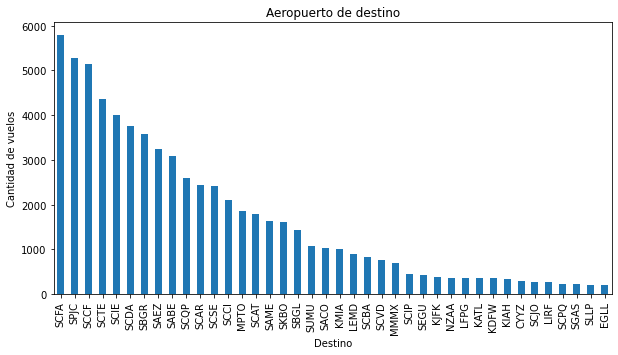

In [5]:
df["Des-O"].value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
plt.title("Aeropuerto de destino")
plt.ylabel("Cantidad de vuelos")
plt.xlabel("Destino");

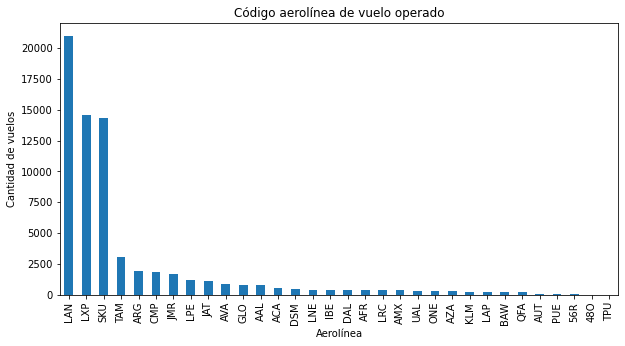

In [6]:
df["Emp-O"].value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
plt.title("Código aerolínea de vuelo operado")
plt.ylabel("Cantidad de vuelos")
plt.xlabel("Aerolínea");

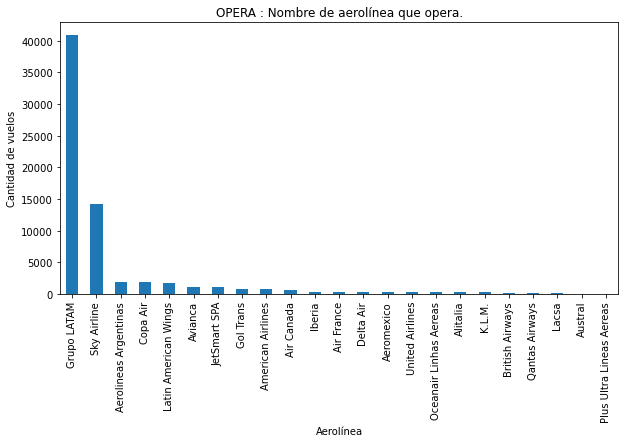

In [7]:
df["OPERA"].value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
plt.title("OPERA : Nombre de aerolínea que opera.")
plt.ylabel("Cantidad de vuelos")
plt.xlabel("Aerolínea");

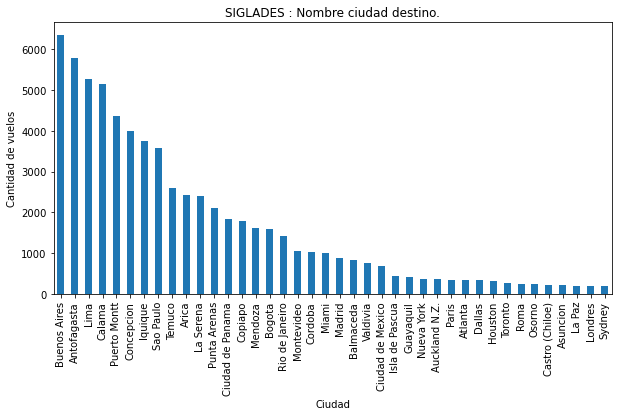

In [8]:
df["SIGLADES"].value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
plt.title("SIGLADES : Nombre ciudad destino.")
plt.ylabel("Cantidad de vuelos")
plt.xlabel("Ciudad");

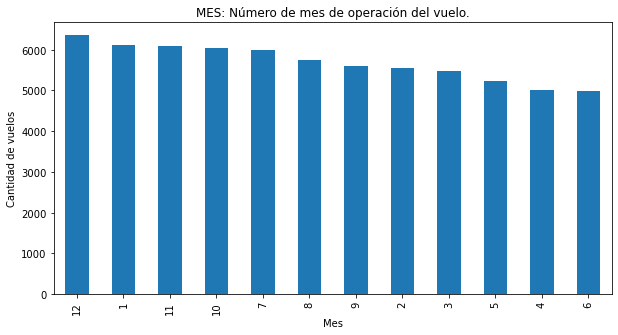

In [9]:
df["MES"].value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
plt.title("MES: Número de mes de operación del vuelo.")
plt.ylabel("Cantidad de vuelos")
plt.xlabel("Mes");

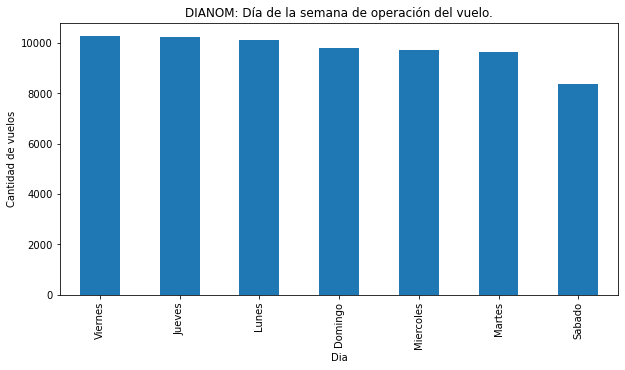

In [10]:
df["DIANOM"].value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
plt.title("DIANOM: Día de la semana de operación del vuelo.")
plt.ylabel("Cantidad de vuelos")
plt.xlabel("Dia");

## 2. Genera las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv:
- temporada_alta : 1 si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no.
- dif_min : diferencia en minutos entre Fecha-O y Fecha-I .
- atraso_15 : 1 si dif_min > 15, 0 si no.
- periodo_dia : mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a Fecha-I .

In [11]:
cond1 = df["Fecha-I"] > datetime(2017, 12, 15)
cond2 = df["Fecha-I"] < datetime(2017, 3, 3)

cond3 = df["Fecha-I"] > datetime(2017, 7, 15)
cond4 = df["Fecha-I"] < datetime(2017, 7, 31)

cond5 = df["Fecha-I"] > datetime(2017, 9, 11)
cond6 = df["Fecha-I"] < datetime(2017, 9, 30)

df["temporada_alta"] = np.where(cond1 | cond2 | (cond3 & cond4) | (cond5 & cond6), "1", "0")

In [12]:
df[df["temporada_alta"]=="1"]["Fecha-O"]

0       2017-01-01 23:33:00
1       2017-01-02 23:39:00
2       2017-01-03 23:39:00
3       2017-01-04 23:33:00
4       2017-01-05 23:28:00
                ...        
68201   2017-12-22 15:41:00
68202   2017-12-25 15:11:00
68203   2017-12-27 15:35:00
68204   2017-12-29 15:08:00
68205   2017-12-31 15:04:00
Name: Fecha-O, Length: 22211, dtype: datetime64[ns]

In [13]:
df["dif_min"] = (df["Fecha-O"] - df["Fecha-I"]) / np.timedelta64(1,'m') 

In [14]:
df[["dif_min", "Fecha-O", "Fecha-I"]].head()

,dif_min,Fecha-O,Fecha-I
0,3.0,2017-01-01 23:33:00,2017-01-01 23:30:00
1,9.0,2017-01-02 23:39:00,2017-01-02 23:30:00
2,9.0,2017-01-03 23:39:00,2017-01-03 23:30:00
3,3.0,2017-01-04 23:33:00,2017-01-04 23:30:00
4,-2.0,2017-01-05 23:28:00,2017-01-05 23:30:00


In [15]:
df["atraso_15"] = np.where(df.dif_min > 15, "1", "0")
df[df["atraso_15"]=="1"][["dif_min", "Fecha-O", "Fecha-I", "atraso_15"]].head()

,dif_min,Fecha-O,Fecha-I,atraso_15
5,34.0,2017-01-07 00:04:00,2017-01-06 23:30:00,1
8,40.0,2017-01-10 00:10:00,2017-01-09 23:30:00,1
9,69.0,2017-01-12 00:39:00,2017-01-11 23:30:00,1
23,52.0,2017-01-06 22:52:00,2017-01-06 22:00:00,1
26,26.0,2017-01-09 22:26:00,2017-01-09 22:00:00,1


In [16]:
df[df["atraso_15"]=="0"][["dif_min", "Fecha-O", "Fecha-I", "atraso_15"]].head()

,dif_min,Fecha-O,Fecha-I,atraso_15
0,3.0,2017-01-01 23:33:00,2017-01-01 23:30:00,0
1,9.0,2017-01-02 23:39:00,2017-01-02 23:30:00,0
2,9.0,2017-01-03 23:39:00,2017-01-03 23:30:00,0
3,3.0,2017-01-04 23:33:00,2017-01-04 23:30:00,0
4,-2.0,2017-01-05 23:28:00,2017-01-05 23:30:00,0


In [17]:
df["hour"] = df["Fecha-I"].dt.hour
df["hour"].head()

0    23
1    23
2    23
3    23
4    23
Name: hour, dtype: int64

In [18]:
df.loc[(df.hour >= 5) & (df.hour < 12), "periodo_dia"] = "mañana"
df.loc[(df.hour >= 12) & (df.hour < 19), "periodo_dia"] = "tarde"
df.loc[(df.hour >= 19) | (df.hour < 5), "periodo_dia"] = "noche"
df.periodo_dia.unique()

array(['noche', 'tarde', 'mañana'], dtype=object)

In [19]:
df[["temporada_alta", "dif_min", "atraso_15", "periodo_dia"]].to_csv("synthetic_features.csv")

## 3. ¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo? ¿Qué variables esperarías que más influyeran en predecir atrasos?


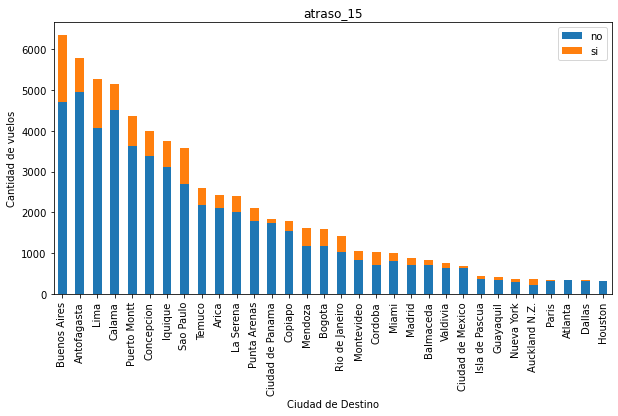

In [20]:
df_crosstab = pd.crosstab(index=df['SIGLADES'], columns=df['atraso_15'])
df_crosstab.columns = ["no", "si"]
df_crosstab["vuelos"] = df_crosstab.no + df_crosstab.si
df_crosstab = df_crosstab.sort_values(by="vuelos", ascending=False)
df_crosstab = df_crosstab[["no", "si"]]
df_crosstab.head(32).plot(kind='bar', stacked=True, figsize=(10,5));
plt.title("atraso_15")
plt.ylabel("Cantidad de vuelos")
plt.xlabel("Ciudad de Destino");


SIGLADES,Buenos Aires,Antofagasta,Lima,Calama,Puerto Montt,Concepcion,Iquique,Sao Paulo,Temuco,Arica,La Serena,Punta Arenas,Ciudad de Panama,Copiapo,Mendoza,Bogota,Rio de Janeiro,Montevideo,Cordoba,Miami
si_100,25.6,14.6,23.0,12.2,16.8,15.6,17.1,24.7,15.6,13.5,16.2,15.4,6.3,13.6,27.3,25.9,28.2,20.6,30.1,19.1
no_100,74.4,85.4,77.0,87.8,83.2,84.4,82.9,75.3,84.4,86.5,83.8,84.6,93.7,86.4,72.7,74.1,71.8,79.4,69.9,80.9


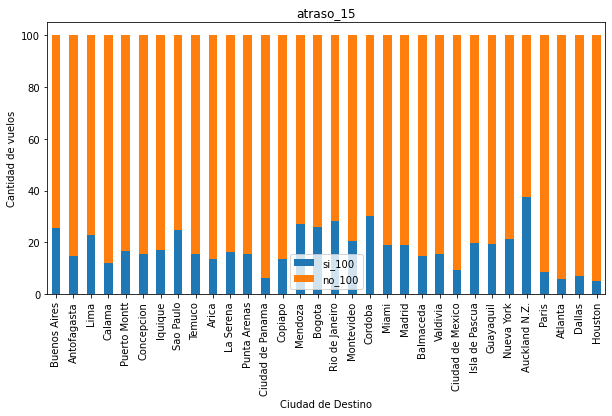

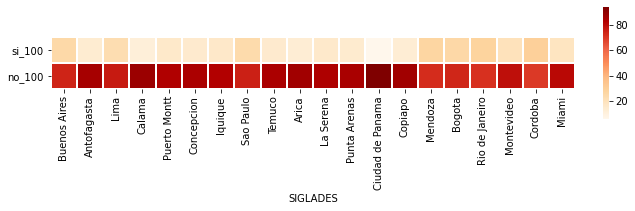

In [21]:
df_crosstab["vuelos"] = df_crosstab.no + df_crosstab.si

df_crosstab["si_100"] = df_crosstab["si"] / df_crosstab["vuelos"] *100
df_crosstab["no_100"] = df_crosstab["no"] / df_crosstab["vuelos"] *100

df_crosstab = df_crosstab[["si_100", "no_100"]]
df_crosstab.head(32).plot(kind='bar', stacked=True, figsize=(10,5));
plt.title("atraso_15")
plt.ylabel("Cantidad de vuelos")
plt.xlabel("Ciudad de Destino");

display(df_crosstab.head(20).transpose().round(1))

plt.figure(figsize=(10,10))
g = sns.heatmap(
    df_crosstab.head(20).transpose(), 
    square=True, # make cells square
    cbar_kws={'fraction' : 0.01}, # shrink colour bar
    cmap='OrRd', # use orange/red colour map
    linewidth=1 # space between cells
)


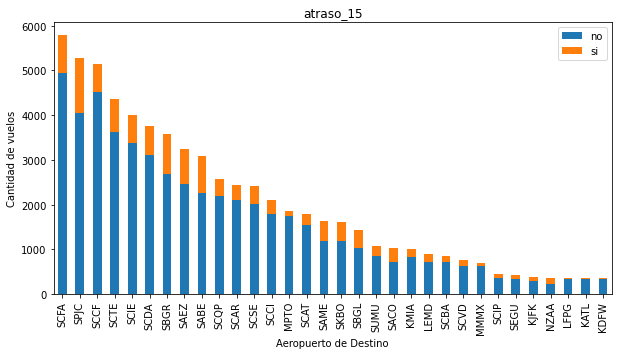

In [22]:
df_crosstab = pd.crosstab(index=df['Des-I'], columns=df['atraso_15'])
df_crosstab.columns = ["no", "si"]
df_crosstab["vuelos"] = df_crosstab.no + df_crosstab.si
df_crosstab = df_crosstab.sort_values(by="vuelos", ascending=False)
df_crosstab = df_crosstab[["no", "si"]]
df_crosstab.head(32).plot(kind='bar', stacked=True, figsize=(10,5));
plt.title("atraso_15")
plt.ylabel("Cantidad de vuelos")
plt.xlabel("Aeropuerto de Destino");


Des-I,SCFA,SPJC,SCCF,SCTE,SCIE,SCDA,SBGR,SAEZ,SABE,SCQP,SCAR,SCSE,SCCI,MPTO,SCAT,SAME,SKBO,SBGL,SUMU,SACO
si_100,14.6,23.0,12.2,16.8,15.6,17.1,24.7,24.4,26.8,15.5,13.5,16.2,15.4,6.3,13.6,27.3,25.9,28.2,20.6,30.1
no_100,85.4,77.0,87.8,83.2,84.4,82.9,75.3,75.6,73.2,84.5,86.5,83.8,84.6,93.7,86.4,72.7,74.1,71.8,79.4,69.9


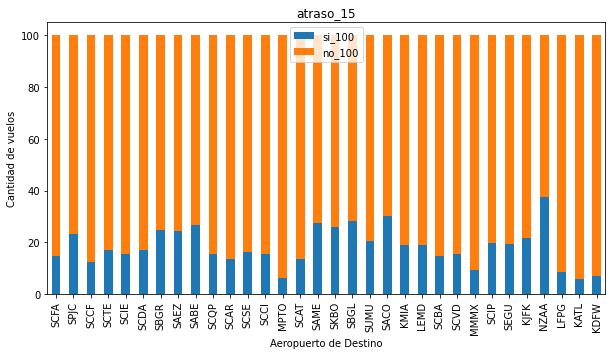

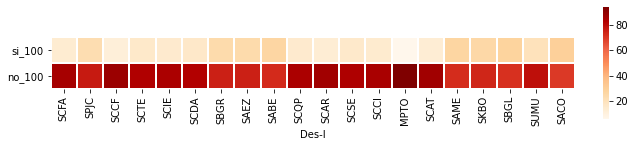

In [23]:
df_crosstab["vuelos"] = df_crosstab.no + df_crosstab.si

df_crosstab["si_100"] = df_crosstab["si"] / df_crosstab["vuelos"] *100
df_crosstab["no_100"] = df_crosstab["no"] / df_crosstab["vuelos"] *100

df_crosstab = df_crosstab[["si_100", "no_100"]]
df_crosstab.head(32).plot(kind='bar', stacked=True, figsize=(10,5));
plt.title("atraso_15")
plt.ylabel("Cantidad de vuelos")
plt.xlabel("Aeropuerto de Destino");

display(df_crosstab.head(20).transpose().round(1))

plt.figure(figsize=(10,10))
g = sns.heatmap(
    df_crosstab.head(20).transpose(), 
    square=True, # make cells square
    cbar_kws={'fraction' : 0.01}, # shrink colour bar
    cmap='OrRd', # use orange/red colour map
    linewidth=1 # space between cells
)


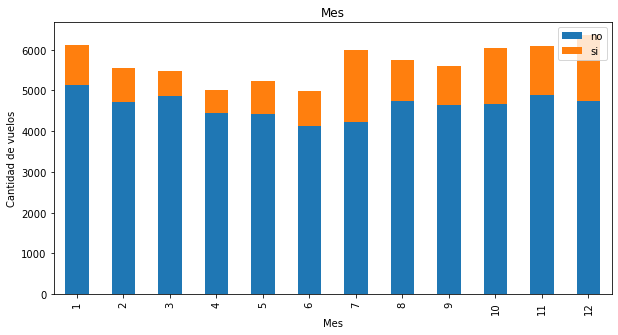

In [24]:
df_crosstab = pd.crosstab(index=df['MES'], columns=df['atraso_15'])
df_crosstab.columns = ["no", "si"]
df_crosstab["vuelos"] = df_crosstab.no + df_crosstab.si
# df_crosstab = df_crosstab.sort_values(by="vuelos", ascending=False)
df_crosstab = df_crosstab[["no", "si"]]
df_crosstab.plot(kind='bar', stacked=True, figsize=(10,5));
plt.title("Mes")
plt.ylabel("Cantidad de vuelos")
plt.xlabel("Mes");


MES,1,2,3,4,5,6,7,8,9,10,11,12
si_100,16.0,15.2,11.5,11.7,15.8,17.1,29.3,17.3,17.2,22.6,19.7,25.4
no_100,84.0,84.8,88.5,88.3,84.2,82.9,70.7,82.7,82.8,77.4,80.3,74.6


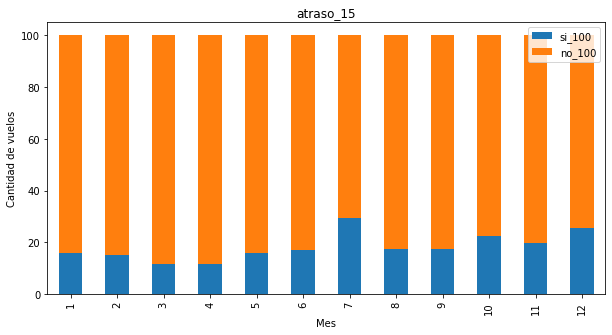

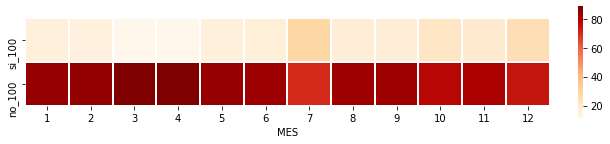

In [25]:
df_crosstab["vuelos"] = df_crosstab.no + df_crosstab.si

df_crosstab["si_100"] = df_crosstab["si"] / df_crosstab["vuelos"] *100
df_crosstab["no_100"] = df_crosstab["no"] / df_crosstab["vuelos"] *100

df_crosstab = df_crosstab[["si_100", "no_100"]]
df_crosstab.plot(kind='bar', stacked=True, figsize=(10,5));
plt.title("atraso_15")
plt.ylabel("Cantidad de vuelos")
plt.xlabel("Mes");

display(df_crosstab.transpose().round(1))

plt.figure(figsize=(10,10))
g = sns.heatmap(
    df_crosstab.head(20).transpose(), 
    square=True, # make cells square
    cbar_kws={'fraction' : 0.01}, # shrink colour bar
    cmap='OrRd', # use orange/red colour map
    linewidth=1 # space between cells
)

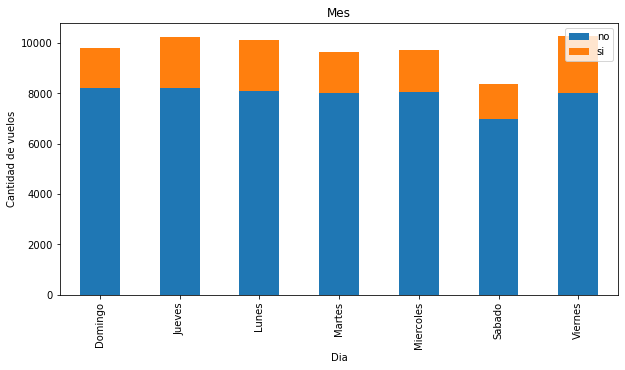

In [26]:
df_crosstab = pd.crosstab(index=df['DIANOM'], columns=df['atraso_15'])
df_crosstab.columns = ["no", "si"]
df_crosstab["vuelos"] = df_crosstab.no + df_crosstab.si
# df_crosstab = df_crosstab.sort_values(by="vuelos", ascending=False)
df_crosstab = df_crosstab[["no", "si"]]
df_crosstab.plot(kind='bar', stacked=True, figsize=(10,5));
plt.title("Mes")
plt.ylabel("Cantidad de vuelos")
plt.xlabel("Dia");


DIANOM,Domingo,Jueves,Lunes,Martes,Miercoles,Sabado,Viernes
si_100,16.1,19.9,20.2,16.9,17.1,16.3,22.2
no_100,83.9,80.1,79.8,83.1,82.9,83.7,77.8


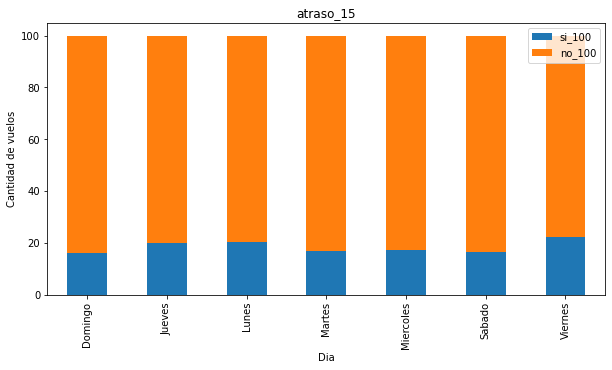

In [27]:
df_crosstab["vuelos"] = df_crosstab.no + df_crosstab.si

df_crosstab["si_100"] = df_crosstab["si"] / df_crosstab["vuelos"] *100
df_crosstab["no_100"] = df_crosstab["no"] / df_crosstab["vuelos"] *100

df_crosstab = df_crosstab[["si_100", "no_100"]]
df_crosstab.plot(kind='bar', stacked=True, figsize=(10,5));
plt.title("atraso_15")
plt.ylabel("Cantidad de vuelos")
plt.xlabel("Dia");

display(df_crosstab.transpose().round(1))

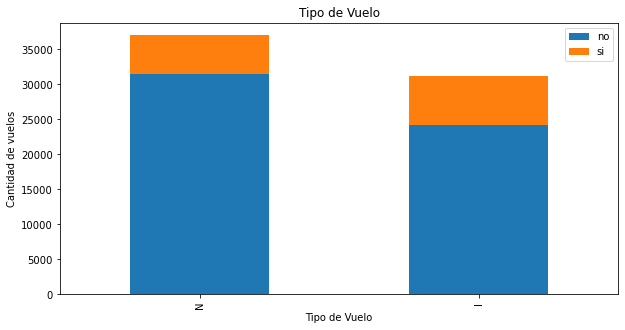

In [28]:
df_crosstab = pd.crosstab(index=df['TIPOVUELO'], columns=df['atraso_15'])
df_crosstab.columns = ["no", "si"]
df_crosstab["vuelos"] = df_crosstab.no + df_crosstab.si
df_crosstab = df_crosstab.sort_values(by="vuelos", ascending=False)
df_crosstab = df_crosstab[["no", "si"]]
df_crosstab.plot(kind='bar', stacked=True, figsize=(10,5));
plt.title("Tipo de Vuelo")
plt.ylabel("Cantidad de vuelos")
plt.xlabel("Tipo de Vuelo");


,si_100,no_100
TIPOVUELO,,
N,15.1,84.9
I,22.6,77.4


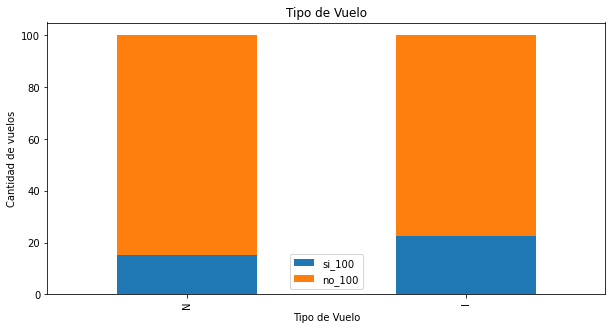

In [29]:
df_crosstab["vuelos"] = df_crosstab.no + df_crosstab.si

df_crosstab["si_100"] = df_crosstab["si"] / df_crosstab["vuelos"] *100
df_crosstab["no_100"] = df_crosstab["no"] / df_crosstab["vuelos"] *100

df_crosstab = df_crosstab[["si_100", "no_100"]]
df_crosstab.plot(kind='bar', stacked=True, figsize=(10,5));
plt.title("Tipo de Vuelo")
plt.ylabel("Cantidad de vuelos")
plt.xlabel("Tipo de Vuelo");
display(df_crosstab.round(1))


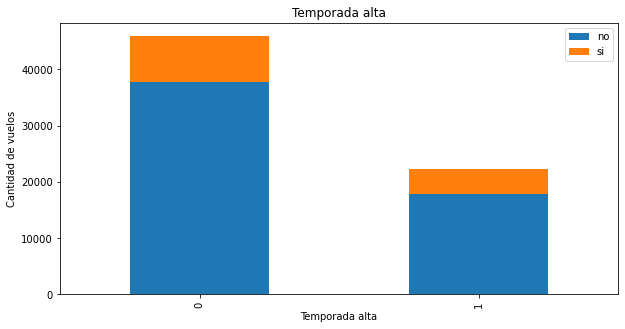

In [30]:
df_crosstab = pd.crosstab(index=df['temporada_alta'], columns=df['atraso_15'])
df_crosstab.columns = ["no", "si"]
df_crosstab["vuelos"] = df_crosstab.no + df_crosstab.si
df_crosstab = df_crosstab.sort_values(by="vuelos", ascending=False)
df_crosstab = df_crosstab[["no", "si"]]
df_crosstab.plot(kind='bar', stacked=True, figsize=(10,5));
plt.title("Temporada alta")
plt.ylabel("Cantidad de vuelos")
plt.xlabel("Temporada alta");


,si_100,no_100
temporada_alta,,
0,17.9,82.1
1,19.6,80.4


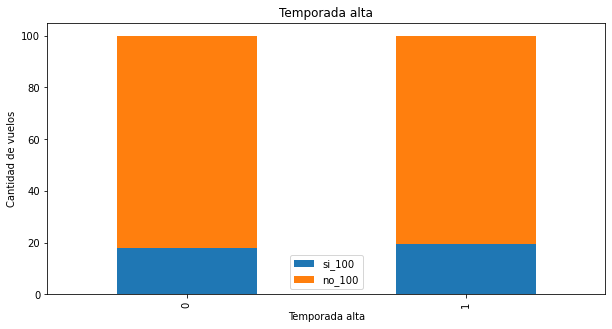

In [31]:
df_crosstab["vuelos"] = df_crosstab.no + df_crosstab.si

df_crosstab["si_100"] = df_crosstab["si"] / df_crosstab["vuelos"] *100
df_crosstab["no_100"] = df_crosstab["no"] / df_crosstab["vuelos"] *100

df_crosstab = df_crosstab[["si_100", "no_100"]]
df_crosstab.plot(kind='bar', stacked=True, figsize=(10,5));
plt.title("Temporada alta")
plt.ylabel("Cantidad de vuelos")
plt.xlabel("Temporada alta");
display(df_crosstab.round(1))

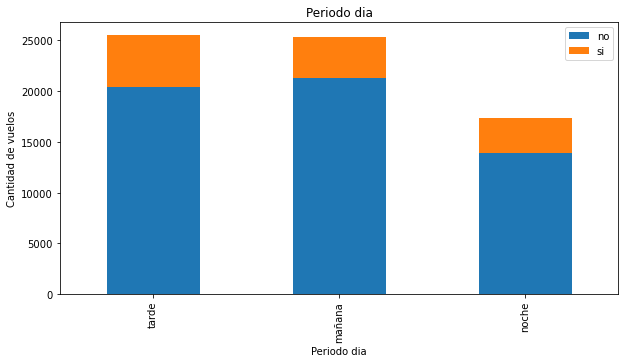

In [32]:
df_crosstab = pd.crosstab(index=df['periodo_dia'], columns=df['atraso_15'])
df_crosstab.columns = ["no", "si"]
df_crosstab["vuelos"] = df_crosstab.no + df_crosstab.si
df_crosstab = df_crosstab.sort_values(by="vuelos", ascending=False)
df_crosstab = df_crosstab[["no", "si"]]
df_crosstab.plot(kind='bar', stacked=True, figsize=(10,5));
plt.title("Periodo dia")
plt.ylabel("Cantidad de vuelos")
plt.xlabel("Periodo dia");


,si_100,no_100
periodo_dia,,
tarde,19.9,80.1
mañana,16.0,84.0
noche,20.0,80.0


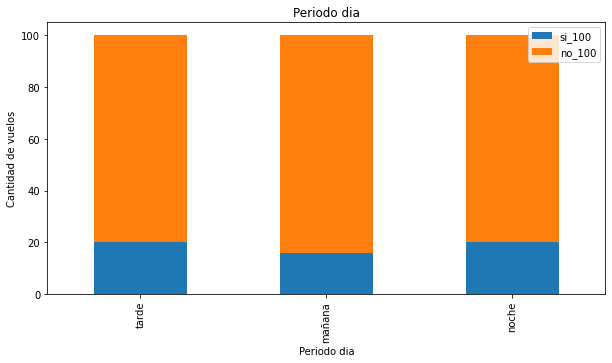

In [33]:
df_crosstab["vuelos"] = df_crosstab.no + df_crosstab.si

df_crosstab["si_100"] = df_crosstab["si"] / df_crosstab["vuelos"] *100
df_crosstab["no_100"] = df_crosstab["no"] / df_crosstab["vuelos"] *100

df_crosstab = df_crosstab[["si_100", "no_100"]]
df_crosstab.plot(kind='bar', stacked=True, figsize=(10,5));
plt.title("Periodo dia")
plt.ylabel("Cantidad de vuelos")
plt.xlabel("Periodo dia");

display(df_crosstab.round(1))

Des-I,CYYZ,EGLL,EGYP,KATL,KDFW,KIAH,KJFK,KLAX,KMCO,KMIA,...,SKBO,SLCB,SLLP,SLVR,SPJC,SPSO,SULS,SUMU,YMML,YSSY
periodo_dia,,,,,,,,,,,,,,,,,,,,,
mañana,NaN,NaN,1.0,1.0,NaN,NaN,0.0,NaN,NaN,0.2,...,0.2,NaN,0.1,0.2,0.2,NaN,0.0,0.2,NaN,NaN
noche,0.4,NaN,NaN,0.1,0.1,0.0,0.2,0.3,0.3,0.2,...,0.1,1.0,0.2,0.3,0.2,NaN,0.3,0.2,NaN,NaN
tarde,0.2,0.1,NaN,0.5,NaN,1.0,NaN,NaN,0.0,1.0,...,0.4,NaN,NaN,NaN,0.3,0.0,NaN,0.2,0.6,0.6


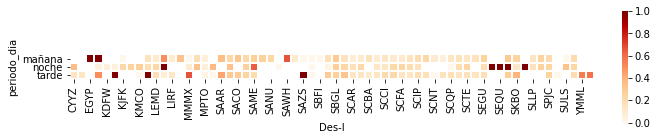

In [34]:


# pd.crosstab([df.Product_Category,df.Product],df.site,values=df.Sales,aggfunc=sum,rownames=['PC','P'],colnames=['S'])

df["atraso_15"] = pd.to_numeric(df['atraso_15']) 

df_crosstab = pd.crosstab(df["Des-I"], df["periodo_dia"], values=df["atraso_15"], aggfunc='mean')
display(df_crosstab.transpose().round(1))

plt.figure(figsize=(10,10))
g = sns.heatmap(
    df_crosstab.transpose(), 
    square=True, # make cells square
    cbar_kws={'fraction' : 0.01}, # shrink colour bar
    cmap='OrRd', # use orange/red colour map
    linewidth=1 # space between cells
)


SIGLADES,Antofagasta,Arica,Asuncion,Atlanta,Auckland N.Z.,Balmaceda,Bariloche,Bogota,Buenos Aires,Calama,...,"San Juan, Arg.",Santa Cruz,Sao Paulo,Sydney,Temuco,Toronto,Tucuman,Ushuia,Valdivia,Washington
periodo_dia,,,,,,,,,,,,,,,,,,,,,
mañana,0.1,0.1,0.3,1.0,NaN,0.2,0.0,0.2,0.2,0.1,...,0.2,0.2,0.2,NaN,0.1,NaN,0.3,0.7,0.2,NaN
noche,0.2,0.2,1.0,0.1,0.4,NaN,NaN,0.1,0.3,0.1,...,NaN,0.3,0.2,NaN,0.3,0.4,NaN,NaN,NaN,0.0
tarde,0.2,0.1,0.3,0.5,0.0,0.1,1.0,0.4,0.3,0.1,...,NaN,NaN,0.3,0.6,0.2,0.2,NaN,NaN,0.2,NaN


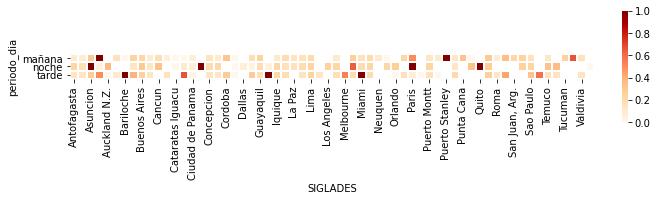

In [35]:
df_crosstab = pd.crosstab(df["SIGLADES"], df["periodo_dia"], values=df["atraso_15"], aggfunc='mean')
display(df_crosstab.transpose().round(1))

plt.figure(figsize=(10,10))
g = sns.heatmap(
    df_crosstab.transpose(), 
    square=True, # make cells square
    cbar_kws={'fraction' : 0.01}, # shrink colour bar
    cmap='OrRd', # use orange/red colour map
    linewidth=1 # space between cells
)


- El tipo de vuelo parece ser determinante en predecir si el vuelo se retrasa (los promedios parecen ser significativamente distintos). 
- De la misma forma, la aerolinea que opera el vuelo parece relevante.
- El periodo del día no parece ser relevante, aunque los vuelos de la mañana parecen ser menos proclives a generar atrasos.


## 4. Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para estimar la probabilidad de atraso de un vuelo. Siéntete libre de generar variables adicionales y/o complementar con variables externas.

In [78]:
from sklearn.model_selection import train_test_split

X_df = df.drop(columns=['atraso_15', 'Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'AÑO', 'SIGLAORI', 'SIGLADES'])

y = df['atraso_15']
y_df = df[['atraso_15']]

X_df.head()

,Emp-O,DIA,MES,DIANOM,TIPOVUELO,OPERA,temporada_alta,dif_min,hour,periodo_dia
0,AAL,1,1,Domingo,I,American Airlines,1,3.0,23,noche
1,AAL,2,1,Lunes,I,American Airlines,1,9.0,23,noche
2,AAL,3,1,Martes,I,American Airlines,1,9.0,23,noche
3,AAL,4,1,Miercoles,I,American Airlines,1,3.0,23,noche
4,AAL,5,1,Jueves,I,American Airlines,1,-2.0,23,noche


In [37]:
class MultiColumnLabelEncoder:
    
    def __init__(self, columns = None):
        self.columns = columns # list of column to encode
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        
        output = X.copy()
        
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname, col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        
        return output
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [38]:
le = MultiColumnLabelEncoder()

X = le.fit_transform(X_df)
X.head()

,Emp-O,DIA,MES,DIANOM,TIPOVUELO,OPERA,temporada_alta,dif_min,hour,periodo_dia
0,2,0,0,0,0,5,1,17,23,1
1,2,1,0,2,0,5,1,23,23,1
2,2,2,0,3,0,5,1,23,23,1
3,2,3,0,4,0,5,1,17,23,1
4,2,4,0,1,0,5,1,12,23,1


In [39]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
X = ohe.fit_transform(X)

In [40]:
# settings
nJobs = psutil.cpu_count()
kFold = 5

print(nJobs)

4


In [41]:
# split entire dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

print(X_train.shape)
print(X_test.shape)

(13641, 312)
(54565, 312)


In [42]:
# helper functions
def evaluate(estimator, X, y, cv, n_jobs=1):
    """
    Print a set of evaluation metrics of given estimator.

    Parameters
    ----------
    estimator : object
        Classifier.
        
    X : array-like, shape (n_samples, n_features)
        Training dataset, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples)
        Label dataset.

    cv : object, optional
        Cross-validation generator.
        
    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    metrics = []
    metrics.append(('Accuracy', 'accuracy'))
    metrics.append(('F1', 'f1_macro'))

    for label, name in metrics:
        results = cross_val_score(estimator, X, y, cv=cv, scoring=name, n_jobs=n_jobs)
        print('%s: %.5f +/- %.5f' % (label, np.mean(results), np.std(results)))

def plot_validation_curve(estimator, title, X, y, param_name, param_range,
                          ylim=None, cv=None, n_jobs=1, plot=plt.plot):
    """
    Generate a plot of learning curve.

    Parameters
    ----------
    estimator : object
        Classifier.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training dataset, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples)
        Label dataset.
        
    param_name : string
        Name of the parameter that will be varied.
        
    param_range : array-like, shape (n_values,)
        The values of the parameter that will be evaluated.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : object, optional
        Cross-validation generator.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
        
    plot: object, optional
        Plotting function.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    train_scores, test_scores = validation_curve(estimator, X, y,
                                                 param_name=param_name,
                                                 param_range=param_range,
                                                 cv=cv, scoring="accuracy",
                                                 n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.xlabel(param_name)
    plt.ylabel("Accuracy")
    lw = 2
    plot(param_range, train_scores_mean, label="Training Accuracy",
         color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plot(param_range, test_scores_mean, label="Cross-validation Accuracy",
         color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), plot=plt.plot):
    """
    Generate a plot of learning curve.

    Parameters
    ----------
    estimator : object
        Classifier.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training dataset, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples)
        Label dataset.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : object, optional
        Cross-validation generator.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    
    plot: object, optional
        Plotting function.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plot(train_sizes, train_scores_mean, 'o-', color="r",
          label="Training Score")
    plot(train_sizes, test_scores_mean, 'o-', color="g",
          label="Cross-validation Score")

    plt.legend(loc=4)
    plt.show()

## Logistic Regression

In [43]:
lr = LogisticRegression(random_state=0).fit(X, y)
lr.fit(X_train, y_train)
yLR = lr.predict(X_test)
scoreLR = accuracy_score(y_test, yLR)

print("Accuracy of Logistic Regression: %0.5f" % scoreLR)

Accuracy of Logistic Regression: 0.99995


## Decision Tree

In [44]:
entropyDT = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0)
entropyDT.fit(X_train, y_train)
yPredEDT = entropyDT.predict(X_test)
scoreEDT = accuracy_score(y_test, yPredEDT)

print("Accuracy of Decision Tree with Entropy: %0.5f" % scoreEDT)

Accuracy of Decision Tree with Entropy: 0.98582


In [45]:
# a decition tree classifier with gini
giniDT = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=0)
giniDT.fit(X_train, y_train)
yPredGDT = giniDT.predict(X_test)
scoreGDT = accuracy_score(y_test, yPredGDT)

print("Accuracy of Decition Tree with Gini: %0.5f" % scoreGDT)

Accuracy of Decition Tree with Gini: 0.99874


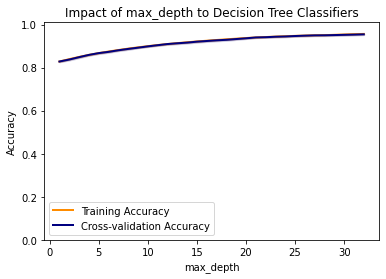

In [46]:
param_name = 'max_depth'
param_range = np.arange(1, 33)
plot_validation_curve(entropyDT, 'Impact of max_depth to Decision Tree Classifiers',
                      X_train, y_train, param_name, param_range, ylim=(0.0, 1.01), cv=kFold,
                      n_jobs=nJobs)

In [47]:
# final decision tree
decisionTree = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=0)
evaluate(decisionTree, X_train, y_train, cv=kFold, n_jobs=nJobs)

Accuracy: 0.89883 +/- 0.00136
F1: 0.78255 +/- 0.00370


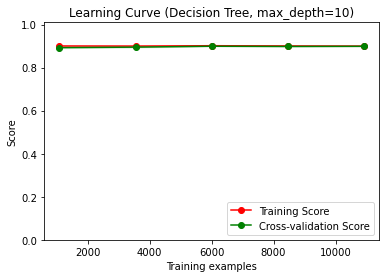

In [48]:
plot_learning_curve(decisionTree, 'Learning Curve (Decision Tree, max_depth=10)',
                    X_train, y_train, ylim=(0.0, 1.01), cv=kFold, n_jobs=nJobs)

In [49]:
nb = GaussianNB()
evaluate(nb, X_train, y_train, cv=kFold, n_jobs=nJobs)

Accuracy: 0.99787 +/- 0.00054
F1: 0.99646 +/- 0.00090


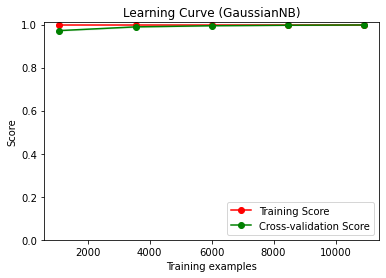

In [50]:
plot_learning_curve(nb, 'Learning Curve (GaussianNB)',
                    X_train, y_train, ylim=(0.0, 1.01), cv=kFold, n_jobs=nJobs)

## Artificial Neural Network

In [51]:
maxIter = 400
params = [
    {'learning_rate': 'constant', 'momentum': 0, 'learning_rate_init': 0.2},
    {'learning_rate': 'constant', 'momentum': .9, 'nesterovs_momentum': False,
     'learning_rate_init': 0.2},
    {'learning_rate': 'constant', 'momentum': .9, 'nesterovs_momentum': True,
     'learning_rate_init': 0.2},
    {'learning_rate': 'invscaling', 'momentum': 0, 'learning_rate_init': 0.2},
    {'learning_rate': 'invscaling', 'momentum': .9, 'nesterovs_momentum': True,
     'learning_rate_init': 0.2},
    {'learning_rate': 'invscaling', 'momentum': .9, 'nesterovs_momentum': False,
     'learning_rate_init': 0.2}
]
labels = [
    "constant learning-rate", "constant with momentum",
    "constant with Nesterov's momentum",
    "inv-scaling learning-rate", "inv-scaling with momentum",
    "inv-scaling with Nesterov's momentum"
]

In [52]:
def train_mlp(solver, X_train, y_train):
    for label, param in zip(labels, params):
        mlp = MLPClassifier(solver=solver, max_iter=maxIter, **param)
        mlp.fit(X_train, y_train)
        print("%s + %s" % (solver, label))
        print("\tTraining set score: %f" % mlp.score(X_train, y_train))
        print("\tTraining set loss: %f" % mlp.loss_)

In [53]:
# solver = 'lbfgs'
# train_mlp(solver, X_train, y_train)

In [54]:
# solver = 'sgd'
# train_mlp(solver, X_train, y_train)

In [55]:
# solver = 'adam'
# train_mlp(solver, X_train, y_train)

In [56]:
solver = 'lbfgs'
param = {'learning_rate_init': 0.2}
mlp = MLPClassifier(solver=solver, max_iter=maxIter, **param)
evaluate(mlp, X_train, y_train, cv=kFold, n_jobs=nJobs)

Accuracy: 0.99971 +/- 0.00036
F1: 0.99939 +/- 0.00054


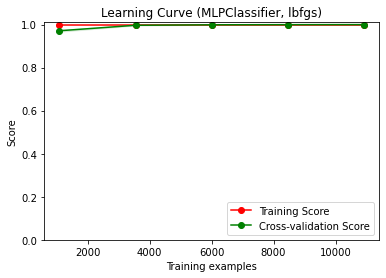

In [57]:
plot_learning_curve(mlp, 'Learning Curve (MLPClassifier, lbfgs)',
                    X_train, y_train, ylim=(0.0, 1.01), cv=kFold, n_jobs=nJobs)

## Support Vector Machine

In [58]:
maxIter = 400
params = [
    {'penalty': 'l1', 'loss': 'squared_hinge', 'dual': False},
    {'penalty': 'l2', 'loss': 'squared_hinge', 'dual': True},
    {'penalty': 'l2', 'loss': 'squared_hinge', 'dual': False}
]
labels = [
    "l1 + squared_hinge + dual: false", "l2 + squared_hinge + dual: true",
    "l2 + squared_hinge + dual: false"
]

In [59]:
def train_svm(X_train, y_train):
    for label, param in zip(labels, params):
        svm = LinearSVC(max_iter=maxIter, **param)
        svm.fit(X_train, y_train)
        print("%s" % (label))
        print("\tTraining set score: %f" % svm.score(X_train, y_train))

In [60]:
train_svm(X_train, y_train)

l1 + squared_hinge + dual: false
	Training set score: 1.000000
l2 + squared_hinge + dual: true
	Training set score: 1.000000
l2 + squared_hinge + dual: false
	Training set score: 1.000000


The above results of different hyperparameter combinations indicate the best configuration is {'penalty': 'l1', 'loss': 'squared_hinge', 'dual': False}

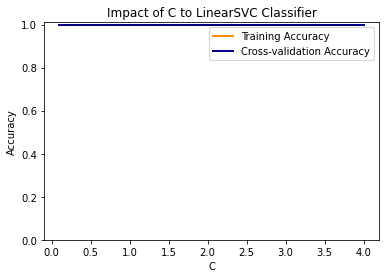

In [61]:
param_name = 'C'
param_range = np.arange(0.1, 4.1, 0.1)
param = {'penalty': 'l1', 'loss': 'squared_hinge', 'dual': False}
plot_validation_curve(LinearSVC(max_iter=maxIter, **param),
                      'Impact of C to LinearSVC Classifier',
                      X_train, y_train, param_name, param_range, ylim=(0.0, 1.01), cv=kFold,
                      n_jobs=nJobs)

In [62]:
param = {'penalty': 'l1', 'loss': 'squared_hinge', 'dual': False, 'C': 2.1}
svm = LinearSVC(max_iter=maxIter, **param)
evaluate(svm, X_train, y_train, cv=kFold, n_jobs=nJobs)

Accuracy: 1.00000 +/- 0.00000
F1: 1.00000 +/- 0.00000


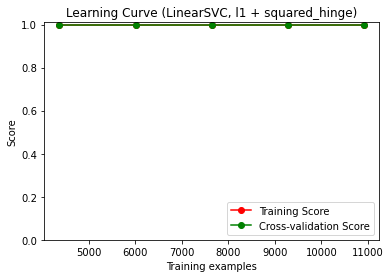

In [63]:
plot_learning_curve(svm, 'Learning Curve (LinearSVC, l1 + squared_hinge)',
                    X_train, y_train, ylim=(0.0, 1.01), cv=kFold, n_jobs=nJobs, train_sizes=np.linspace(.4, 1.0, 5))

## Ensemble Classifier

In [64]:
param = {'n_estimators': 17, 'max_depth': 10}
rfc = RandomForestClassifier(n_jobs=nJobs, **param)
evaluate(rfc, X_train, y_train, cv=kFold, n_jobs=nJobs)

Accuracy: 0.86174 +/- 0.01119
F1: 0.63609 +/- 0.03444


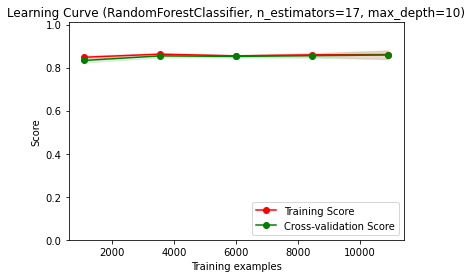

In [65]:
plot_learning_curve(rfc, 'Learning Curve (RandomForestClassifier, n_estimators=17, max_depth=10)',
                    X_train, y_train, ylim=(0.0, 1.01), cv=kFold, n_jobs=nJobs)

# Make Predictions and Evaluate Performance on The Test Set

## Logistic Regression

In [66]:
evaluate(lr, X_test, y_test, cv=kFold, n_jobs=nJobs)

Accuracy: 1.00000 +/- 0.00000
F1: 1.00000 +/- 0.00000


## Decision Tree

In [67]:
evaluate(decisionTree, X_test, y_test, cv=kFold, n_jobs=nJobs)

Accuracy: 0.89911 +/- 0.00120
F1: 0.78331 +/- 0.00336


## Naïve Bayes

In [68]:
evaluate(nb, X_test, y_test, cv=kFold, n_jobs=nJobs)

Accuracy: 1.00000 +/- 0.00000
F1: 1.00000 +/- 0.00000


## Artificial Neural Network

In [69]:
evaluate(mlp, X_test, y_test, cv=kFold, n_jobs=nJobs)

Accuracy: 0.99996 +/- 0.00004
F1: 0.99988 +/- 0.00015


## Support Vector Machine

In [70]:
evaluate(svm, X_test, y_test, cv=kFold, n_jobs=nJobs)

Accuracy: 1.00000 +/- 0.00000
F1: 1.00000 +/- 0.00000


## Ensemble Classifier

In [71]:
evaluate(rfc, X_test, y_test, cv=kFold, n_jobs=nJobs)

Accuracy: 0.85256 +/- 0.01157
F1: 0.64033 +/- 0.06606


## 5. Evalúa tu modelo. ¿Qué performance tiene? ¿Qué métricas usaste para evaluar esa performance y por qué? ¿Por qué elegiste ese algoritmo en particular? ¿Qué variables son las que más influyen en la predicción? ¿Cómo podrías mejorar la performance?

- Elegí Logistic Regression ya que tiene un buen Accuracy y ofrece la posibilidad de interpretar los coeficientes de la regresión.
- La métrica relevante es Accuracy ya que el objetivo es predecir si el vuelo se atrasa.


In [72]:
X_df.columns

Index(['Emp-O', 'DIA', 'MES', 'DIANOM', 'TIPOVUELO', 'OPERA', 'temporada_alta',
       'dif_min', 'hour', 'periodo_dia'],
      dtype='object')

In [82]:
X_df.head()

,Emp-O,DIA,MES,DIANOM,TIPOVUELO,OPERA,temporada_alta,dif_min,hour,periodo_dia
0,AAL,1,1,Domingo,I,American Airlines,1,3.0,23,noche
1,AAL,2,1,Lunes,I,American Airlines,1,9.0,23,noche
2,AAL,3,1,Martes,I,American Airlines,1,9.0,23,noche
3,AAL,4,1,Miercoles,I,American Airlines,1,3.0,23,noche
4,AAL,5,1,Jueves,I,American Airlines,1,-2.0,23,noche


In [84]:
import statsmodels.api as sm
from statsmodels.formula.api import logit

In [79]:
y_df.columns

Index(['atraso_15'], dtype='object')

In [81]:
data = X_df.copy()
data['atraso_15'] = y_df

In [89]:
atraso_mod = logit("atraso_15 ~ TIPOVUELO + OPERA + DIA + MES"
                   "+ temporada_alta + periodo_dia ", data).fit()

Optimization terminated successfully.
         Current function value: 0.449707
         Iterations 8


In [90]:
print(atraso_mod.summary())

                           Logit Regression Results                           
Dep. Variable:              atraso_15   No. Observations:                68206
Model:                          Logit   Df Residuals:                    68138
Method:                           MLE   Df Model:                           67
Date:                Wed, 09 Sep 2020   Pseudo R-squ.:                 0.06077
Time:                        15:57:05   Log-Likelihood:                -30673.
converged:                       True   LL-Null:                       -32657.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -1.8512      0.096    -19.214      0.000      -2.040      -1.662
TIPOVUELO[T.N]                       -0.5974      0.023    -25

Los efectos marginales en la regresión lineal entregan el efecto en la probabilidad de la variable exógenade una unidad mas de la variable

In [91]:
mfx = atraso_mod.get_margeff()
print(mfx.summary())

        Logit Marginal Effects       
Dep. Variable:              atraso_15
Method:                          dydx
At:                           overall
                                       dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
TIPOVUELO[T.N]                       -0.0845      0.003    -26.202      0.000      -0.091      -0.078
OPERA[T.Aeromexico]                  -0.3602      0.046     -7.802      0.000      -0.451      -0.270
OPERA[T.Air Canada]                   0.1366      0.014      9.532      0.000       0.109       0.165
OPERA[T.Air France]                  -0.1929      0.028     -6.825      0.000      -0.248      -0.138
OPERA[T.Alitalia]                    -0.1255      0.029     -4.310      0.000      -0.183      -0.068
OPERA[T.American Airlines]           -0.2327      0.022    -10.539      0.000      -0.276      -0.189
OPERA[T.Austral]                

### Conclusiones:
A partir de los resultados (el efecto marginal y los p-values), se tiene que para un vuelo representativo de la muestra es significativo y relevante lo siguiente:

- Si el vuelo es en el mes 7 (Julio) es un 12% mas probable de tener un retraso.
- Si el vuelo es internacional es 8% mas probable de en tener un retraso.
- La aerolineas que opera el vuelo es un buen determinante de la probabilidad de retraso del vuelo. En particular:
    - Si el vuelo es United Airlines es casi un 27% menos probable de tener un retraso.
    - Aeromexico es 36% menos probable de tener un retraso.
    - Qantas Airways es un 20% mas probable de tener un retraso.
    - American Airlines es un 23% menos probable de tener un retraso.
    

### Futuros análisis
- Creo sería interesante analizar si el atraso es determinado por atrasos de los pasajeros o por mala gestiñon de la aerolineas.
- Una posible fora de hacer esto sería ver el horario del check-in en el aeropuerto o tambien contabilizar el horario de llegada de los pasajeros al aeropuerto

- Un espeficicación interesate sería hacer un modelo bietapico donde:
    - Etapa 1: determinantes del retraso de los pasajeros al aeropuerto (donde estaría el horario: tarde, mañana, noche)
    - Etapa 2: determinantes del retraso del vuelo (donde se ocuparía la predicción de la primera etapa).
